In [13]:
from Bio import SeqIO
import numpy as np
from matplotlib import pyplot as plt
from tqdm import *

AA_LIST = list("ACDEFGHIKLMNPQRSTVWY-")
AA_TO_INDEX = {aa: i for i, aa in enumerate(AA_LIST)}
AA_DIM = len(AA_LIST)

class ECV_funcs:

    def read_msa(fasta_file: str,
                 gap_threshold: float = 0.25) -> list:
        '''
        
        '''

        alignment = SeqIO.parse(fasta_file, "fasta")
        return [''.join(a for a in str(record.seq) if a in AA_LIST) for record in alignment if (str(record.seq).count('-') / len(str(record.seq))) <= gap_threshold]
    
    def encode_one_hot(fasta_file: str):
        '''
        
        '''

        msa_seqs = ECV_funcs.read_msa(fasta_file)
        N = len(msa_seqs)
        L = len(msa_seqs[0])
        one_hot = np.zeros((N, L, AA_DIM))
        
        for i, seq in enumerate(msa_seqs):
            for j, aa in enumerate(seq):
                if aa in AA_TO_INDEX:
                    one_hot[i, j, AA_TO_INDEX[aa]] = 1.0

        return one_hot

    def compute_evolution_coupling(fasta_file: str,
                                    position: int = None,
                                    pic_out_file: str = None):
            """
            position: starting from 1
            """
            
            one_hot = ECV_funcs.encode_one_hot(fasta_file)  # shape (N, L, D)
            N, L, D = one_hot.shape

            mean_pos = np.mean(one_hot, axis=0)      # shape (L, D)
            mean_global = np.mean(one_hot, axis=1)   # shape (N, D)
            mean_global_mean = np.mean(mean_global, axis=0)  # shape (D,)

            X_bar = mean_global - mean_global_mean   # shape (N, D)
            var_bar = np.mean(np.sum(X_bar**2, axis=1))  # scalar

            coupling = np.zeros((L, L))

            for i in tqdm(range(L)):
                Xi = one_hot[:, i, :] - mean_pos[i, :]  # shape (N, D)
                var_i = np.mean(np.sum(Xi**2, axis=1))  # scalar

                for j in range(i+1, L):
                    if i == j:
                        continue

                    Xj = one_hot[:, j, :] - mean_pos[j, :]
                    var_j = np.mean(np.sum(Xj**2, axis=1))

                    cov_ij = np.mean(np.sum(Xi * Xj, axis=1))
                    cov_ib = np.mean(np.sum(Xi * X_bar, axis=1))
                    cov_jb = np.mean(np.sum(Xj * X_bar, axis=1))

                    denominator = np.sqrt(var_i * var_j)
                    if denominator == 0:
                        coupling[i, j] = 0
                        continue

                    direct_coupling = cov_ij / denominator
                    background_proj = (cov_ib * cov_jb) / (var_bar * denominator)
                    coupling[i, j] = direct_coupling - background_proj
                    coupling[j, i] = coupling[i, j]

            independent_score = None
            if position is not None:
                independent_score = np.sum(coupling[position - 1, :]) / (L - 1)
            
            plt.imshow(coupling, cmap='viridis')
            plt.title("Evolutionary Coupling Matrix")
            plt.colorbar()
            # plt.savefig(pic_out_file, bbox_inches='tight')

            return coupling, independent_score

100%|██████████| 302/302 [01:03<00:00,  4.73it/s]


[[ 0.          0.35681893  0.22890577 ... -0.00617518  0.01036009
   0.01463139]
 [ 0.35681893  0.          0.27981462 ...  0.0027582   0.00524138
   0.00601603]
 [ 0.22890577  0.27981462  0.         ...  0.00864854  0.00246643
   0.0129935 ]
 ...
 [-0.00617518  0.0027582   0.00864854 ...  0.          0.34053829
   0.32617847]
 [ 0.01036009  0.00524138  0.00246643 ...  0.34053829  0.
   0.4090068 ]
 [ 0.01463139  0.00601603  0.0129935  ...  0.32617847  0.4090068
   0.        ]]
-0.0029791827491214085


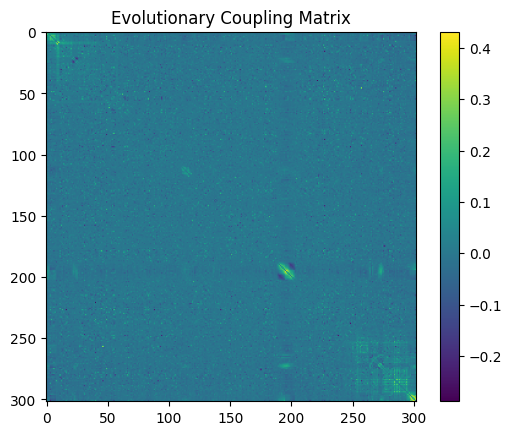

In [14]:
msa_file = '/sddn/yyf_work/sugarswitch/uricase/1ws2.a3m'

coupling_matrix, score = ECV_funcs.compute_evolution_coupling(msa_file, 81)
print(coupling_matrix)
print(score)

In [30]:
from Bio import SeqIO
import numpy as np
from matplotlib import pyplot as plt
from tqdm import *

AA_LIST = list("ACDEFGHIKLMNPQRSTVWY-")
AA_TO_INDEX = {aa: i for i, aa in enumerate(AA_LIST)}
AA_DIM = len(AA_LIST)

class ECV_funcs:

    def read_msa(fasta_file: str,
                 gap_threshold: float = 0.25) -> list:
        '''
        
        '''

        alignment = SeqIO.parse(fasta_file, "fasta")
        return [''.join(a for a in str(record.seq) if a in AA_LIST) for record in alignment if (str(record.seq).count('-') / len(str(record.seq))) <= gap_threshold]
    
    def encode_one_hot(fasta_file: str):
        '''
        
        '''

        msa_seqs = ECV_funcs.read_msa(fasta_file)
        N = len(msa_seqs)
        L = len(msa_seqs[0])
        one_hot = np.zeros((N, L, AA_DIM))
        
        for i, seq in enumerate(msa_seqs):
            for j, aa in enumerate(seq):
                if aa in AA_TO_INDEX:
                    one_hot[i, j, AA_TO_INDEX[aa]] = 1.0

        return one_hot

    def compute_evolution_coupling(fasta_file: str,
                                   position: int = None,
                                   pic_out_file: str = None):
        '''
        position: starting from 1
        '''

        one_hot = ECV_funcs.encode_one_hot(fasta_file)
        N, L, D = one_hot.shape
        one_hot = one_hot.reshape(N, L * D)
        
        mean = np.mean(one_hot, axis=0, keepdims=True)
        one_hot_centered = one_hot - mean

        cov = np.cov(one_hot_centered, rowvar=False)
        
        coupling = np.zeros((L, L))
        for i in range(L):
            for j in range(L):
                block_ij = cov[i*D:(i+1)*D, j*D:(j+1)*D]
                coupling[i, j] = np.linalg.norm(block_ij, ord='fro')

        np.fill_diagonal(coupling, 0)
        independent_score = np.sum(coupling[position-1, :]) / (coupling.shape[0] - 1)

            
        plt.imshow(coupling, cmap='viridis')
        plt.title("Evolutionary Coupling Matrix")
        plt.colorbar()
        # plt.savefig(pic_out_file, bbox_inches='tight')

        return coupling, independent_score

In [51]:
import numpy as np
from Bio import SeqIO
from tqdm import tqdm

class PLMDCA:
    def __init__(self, msa_file: str, q: int = 21, theta: float = 0.2, pseudocount: float = 0.5, gap_threshold: float = 0.25):
        """
        msa_file: 多序列比对（FASTA格式）
        q: 氨基酸种类数（含gap）
        theta: 距离阈值（Hamming）计算序列权重
        """
        self.q = q
        self.theta = theta
        self.pseudocount = pseudocount
        self.gap_threshold = gap_threshold
        self.msa = self.read_msa(msa_file)
        self.N, self.L = self.msa.shape
        self.weights = self.compute_sequence_weights()
        self.freq1, self.freq2 = self.compute_frequencies()
        self.couplings = None
        self.fields = None

    def read_msa(self, msa_file, ):
        
        alignment = SeqIO.parse(msa_file, "fasta")
        aa_list = list("ACDEFGHIKLMNPQRSTVWY-")
        aa_dict = {aa: i for i, aa in enumerate(aa_list)}
        msa_array = [[aa_dict.get(aa, self.q) for aa in str(record.seq)] for record in alignment if (str(record.seq).count('-') / len(str(record.seq)) <= self.gap_threshold) and set(str(record.seq)).issubset(set(aa_list))]

        return np.array(msa_array, dtype=int)

    def compute_sequence_weights(self):
        """Compute sequence weights to down-weight similar sequences."""
        weights = np.ones(self.N)
        for i in range(self.N):
            for j in range(i + 1, self.N):
                identity = np.mean(self.msa[i] == self.msa[j])
                if identity > 1 - self.theta:
                    weights[i] += 1
                    weights[j] += 1
        return 1.0 / weights

    def compute_frequencies(self):
        """Compute one- and two-site frequencies with pseudocounts and weighting."""
        freq1 = np.zeros((self.L, self.q))
        freq2 = np.zeros((self.L, self.L, self.q, self.q))

        for i in range(self.N):
            w = self.weights[i]
            for l in range(self.L):
                freq1[l, self.msa[i, l]] += w
            for l1 in range(self.L):
                for l2 in range(self.L):
                    freq2[l1, l2, self.msa[i, l1], self.msa[i, l2]] += w

        Meff = np.sum(self.weights)
        freq1 = (1 - self.pseudocount) * freq1 / Meff + self.pseudocount / self.q
        freq2 = (1 - self.pseudocount) * freq2 / Meff + self.pseudocount / (self.q ** 2)
        return freq1, freq2

    def one_hot_encode(self):
        X = np.zeros((self.N, self.L * self.q))
        for i in range(self.N):
            for j in range(self.L):
                X[i, j * self.q + self.msa[i, j]] = 1
        return X

    def fit_plm(self, l2: float = 0.01, max_iter: int = 100):
        """
        使用伪似然最大化方法估计耦合矩阵
        """
        from scipy.optimize import minimize

        X = self.one_hot_encode()
        Lq = self.L * self.q
        W = self.weights[:, None]

        def loss(params):
            fields = params[:Lq]
            couplings = params[Lq:].reshape((Lq, Lq))
            couplings = (couplings + couplings.T) / 2  # enforce symmetry

            logits = X @ couplings + fields
            logits = logits.reshape(self.N, self.L, self.q)
            exp_logits = np.exp(logits - logits.max(axis=-1, keepdims=True))
            logZ = np.log(np.sum(exp_logits, axis=-1, keepdims=True))
            probs = exp_logits / np.exp(logZ)

            nll = -np.sum(W * np.sum(X.reshape(self.N, self.L, self.q) * np.log(probs + 1e-10), axis=(1, 2)))
            reg = l2 * np.sum(couplings ** 2)
            return nll + reg

        print("Optimizing PLM...")
        x0 = np.zeros(Lq + Lq * Lq)
        res = minimize(loss, x0, method='L-BFGS-B', options={'maxiter': max_iter})
        final_params = res.x
        self.fields = final_params[:Lq].reshape(self.L, self.q)
        self.couplings = final_params[Lq:].reshape(Lq, Lq).reshape(self.L, self.q, self.L, self.q)

    def compute_direct_information(self, apc=True):
        """
        计算每个位点对的直接信息（DI）并可选地进行APC修正。
        """
        di = np.zeros((self.L, self.L))
        for i in range(self.L):
            for j in range(i + 1, self.L):
                Jij = self.couplings[i, :, j, :]
                pi = self.freq1[i]
                pj = self.freq1[j]
                pi_pj = np.outer(pi, pj)

                # Mirror-sample marginal
                qij = np.exp(Jij) * pi_pj
                qij /= np.sum(qij)

                # DI计算
                di[i, j] = np.sum(qij * (np.log(qij + 1e-9) - np.log(np.outer(pi, pj) + 1e-9)))
                di[j, i] = di[i, j]

        if apc:
            # APC correction
            di_mean_row = np.mean(di, axis=1, keepdims=True)
            di_mean_col = np.mean(di, axis=0, keepdims=True)
            di_mean_all = np.mean(di)
            di_apc = di - di_mean_row * di_mean_col / di_mean_all
            return di_apc
        else:
            return di


/sddn/yyf_work/sugarswitch/scripts_filter/EVcouplings/evcouplings/couplings/pairs.py:129: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stacked_ecs.groupby(["i", "A_i"]).sum()


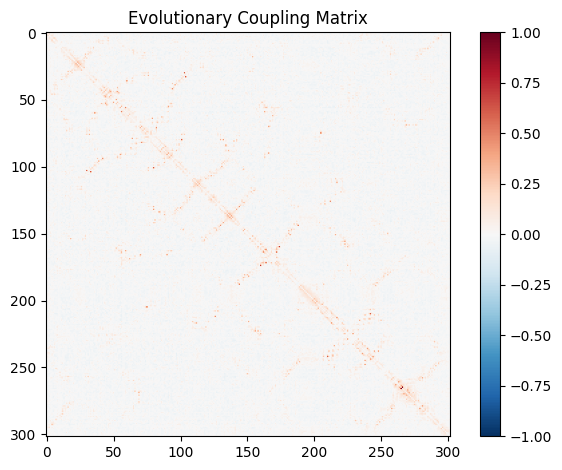

In [1]:
from evc_utils import EVC_funcs
from pathlib import Path

a3m_file = "/sddn/yyf_work/sugarswitch/uricase/1ws2.a3m"
out_dir = "/sddn/yyf_work/sugarswitch/scripts_filter/uricase_evc/"

evc = EVC_funcs(alignment_file=a3m_file, out_dir=out_dir)
sites = evc.run_evc_filters()

In [1]:
from copy import deepcopy
mutations = {1: "X", 3: "Y"}
wt_seq = "ACGT"
wt_seq_list = list(wt_seq)
mut_seq_list = deepcopy(wt_seq_list)
for s, m in mutations.items():
    mut_seq_list[s-1] = m
mut_seq = "".join(mut_seq_list)
print(mut_seq)

XCYT
